**RUN THIS BEFORE JUPYTER!**

```
export HDF5_DISABLE_VERSION_CHECK=1
```

In [1]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import cm
from copy import deepcopy
import multidop
import pyart
import read_brazil_radar as rbr
import tempfile
import os
import glob
import time
%matplotlib inline


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



### Reading radar files

In [2]:
filenames = open("filenames.txt").read().split('\n')

In [3]:
radar_1 = pyart.aux_io.read_gamic(filenames[0])
radar_2 = rbr.read_rainbow_hdf5(filenames[1])
print(radar_1.fields.keys(), radar_2.fields.keys())

['spectrum_width', 'corrected_velocity', 'corrected_reflectivity', 'reflectivity'] ['corrected_reflectivity', 'differential_phase', 'cross_correlation_ratio', 'filtered_differential_phase', 'spectrum_width', 'reflectivity', 'differential_reflectivity', 'specific_differential_phase', 'velocity']


### Performing corrections

In [4]:
cp = deepcopy(radar_1.fields['corrected_reflectivity']['data'])
radar_1.add_field_like('corrected_reflectivity', 'DT', cp, replace_existing=True)
gatefilter = pyart.correct.GateFilter(radar_1)
gatefilter.exclude_masked('corrected_reflectivity')
corr_vel = pyart.correct.dealias_region_based(radar_1, vel_field='corrected_velocity',
                                              keep_original=False, gatefilter=gatefilter,
                                              centered=True)
radar_1.add_field('VT', corr_vel, replace_existing=True)

/home/camila/anaconda2/lib/python2.7/site-packages/pyart/correct/region_dealias.py:267: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)
/home/camila/anaconda2/lib/python2.7/site-packages/pyart/correct/region_dealias.py:267: UserWarning: Velocities outside of the Nyquist interval found in sweep 1.
  warnings.warn(msg, UserWarning)
/home/camila/anaconda2/lib/python2.7/site-packages/pyart/correct/region_dealias.py:267: UserWarning: Velocities outside of the Nyquist interval found in sweep 2.
  warnings.warn(msg, UserWarning)
/home/camila/anaconda2/lib/python2.7/site-packages/pyart/correct/region_dealias.py:267: UserWarning: Velocities outside of the Nyquist interval found in sweep 3.
  warnings.warn(msg, UserWarning)
/home/camila/anaconda2/lib/python2.7/site-packages/pyart/correct/region_dealias.py:267: UserWarning: Velocities outside of the Nyquist interval found in sweep 4.
  warnings.warn(msg, UserWarning)
/home/camila/anacond

In [5]:
cp = deepcopy(radar_2.fields['reflectivity']['data'])
radar_2.add_field_like('reflectivity', 'DT', cp, replace_existing=True)
gatefilter = pyart.correct.GateFilter(radar_2)
gatefilter.exclude_masked('reflectivity')
corr_vel = pyart.correct.dealias_region_based(radar_2, vel_field='velocity',
                                              keep_original=False, gatefilter=gatefilter,
                                              centered=True)
radar_2.add_field('VT', corr_vel, replace_existing=True)

### Comparing corrections: São Roque

In [6]:
xlim, ylim = [[-47.5,-46.5], [-23.3,-22.5]]

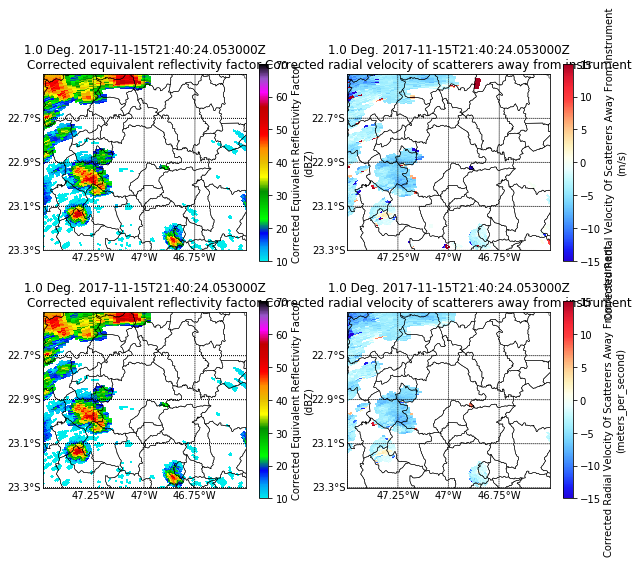

In [7]:
display = pyart.graph.RadarMapDisplay(radar_1)
fig = plt.figure(figsize=(10,8))
fig.set_facecolor('w')

ax1 = fig.add_subplot(221)
display.plot_ppi_map('corrected_reflectivity', 1, vmin=10, vmax=70, shapefile="../Data/GENERAL/shapefiles/sao_paulo",
                     max_lat=ylim[1], min_lat=ylim[0], min_lon=xlim[0], max_lon=xlim[1],
                     lat_lines=np.arange(ylim[0], ylim[1], .2), lon_lines=np.arange(xlim[0], xlim[1], .25))

ax2 = fig.add_subplot(222)
display.plot_ppi_map('corrected_velocity', 1, vmin=-15, vmax=15, shapefile="../Data/GENERAL/shapefiles/sao_paulo",
                     max_lat=ylim[1], min_lat=ylim[0], min_lon=xlim[0], max_lon=xlim[1],
                     lat_lines=np.arange(ylim[0], ylim[1], .2), lon_lines=np.arange(xlim[0], xlim[1], .25))

ax3 = fig.add_subplot(223)
display.plot_ppi_map('DT', 1, vmin=10, vmax=70, shapefile="../Data/GENERAL/shapefiles/sao_paulo",
                     max_lat=ylim[1], min_lat=ylim[0], min_lon=xlim[0], max_lon=xlim[1],
                     lat_lines=np.arange(ylim[0], ylim[1], .2), lon_lines=np.arange(xlim[0], xlim[1], .25),
                     cmap='pyart_NWSRef')

ax4 = fig.add_subplot(224)
display.plot_ppi_map('VT', 1, vmin=-15, vmax=15, shapefile="../Data/GENERAL/shapefiles/sao_paulo",
                     max_lat=ylim[1], min_lat=ylim[0], min_lon=xlim[0], max_lon=xlim[1],
                     lat_lines=np.arange(ylim[0], ylim[1], .2), lon_lines=np.arange(xlim[0], xlim[1], .25),
                     cmap='pyart_BuDRd18')

### Comparing corrections: CTH

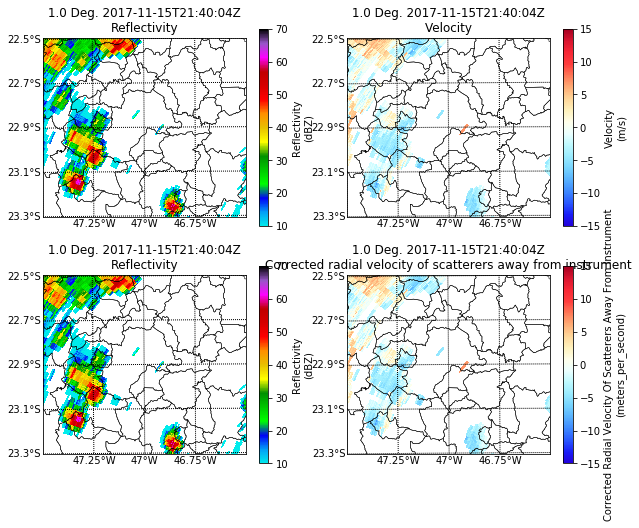

In [8]:
display = pyart.graph.RadarMapDisplay(radar_2)
fig = plt.figure(figsize=(10,8))
fig.set_facecolor('w')

ax1 = fig.add_subplot(221)
display.plot_ppi_map('reflectivity', 0, vmin=10, vmax=70, shapefile="../Data/GENERAL/shapefiles/sao_paulo",
                     max_lat=ylim[1], min_lat=ylim[0], min_lon=xlim[0], max_lon=xlim[1],
                     lat_lines=np.arange(ylim[0], ylim[1], .2), lon_lines=np.arange(xlim[0], xlim[1], .25))

ax2 = fig.add_subplot(222)
display.plot_ppi_map('velocity', 0, vmin=-15, vmax=15, shapefile="../Data/GENERAL/shapefiles/sao_paulo",
                     max_lat=ylim[1], min_lat=ylim[0], min_lon=xlim[0], max_lon=xlim[1],
                     lat_lines=np.arange(ylim[0], ylim[1], .2), lon_lines=np.arange(xlim[0], xlim[1], .25))

ax3 = fig.add_subplot(223)
display.plot_ppi_map('DT', 0, vmin=10, vmax=70, shapefile="../Data/GENERAL/shapefiles/sao_paulo",
                     max_lat=ylim[1], min_lat=ylim[0], min_lon=xlim[0], max_lon=xlim[1],
                     lat_lines=np.arange(ylim[0], ylim[1], .2), lon_lines=np.arange(xlim[0], xlim[1], .25),
                     cmap='pyart_NWSRef')

ax4 = fig.add_subplot(224)
display.plot_ppi_map('VT', 0, vmin=-15, vmax=15, shapefile="../Data/GENERAL/shapefiles/sao_paulo",
                     max_lat=ylim[1], min_lat=ylim[0], min_lon=xlim[0], max_lon=xlim[1],
                     lat_lines=np.arange(ylim[0], ylim[1], .2), lon_lines=np.arange(xlim[0], xlim[1], .25),
                     cmap='pyart_BuDRd18')

In [9]:
radar_1.fields['DT']['missing_value'] = 1.0 * radar_1.fields['DT']['_FillValue']
radar_2.fields['DT']['missing_value'] = 1.0 * radar_2.fields['DT']['data'].fill_value
radar_2.fields['DT']['_FillValue'] = radar_2.fields['DT']['data'].fill_value
radar_1.fields['VT']['missing_value'] = 1.0 * radar_1.fields['VT']['_FillValue']
radar_2.fields['VT']['missing_value'] = 1.0 * radar_2.fields['VT']['data'].fill_value
radar_2.fields['VT']['_FillValue'] = radar_2.fields['VT']['data'].fill_value

### Grid the volumes and add azimuths and elevations

In [10]:
def grid_radar(radar, grid_shape=(20, 301, 301), xlim=(-150000, 150000),
               ylim=(-150000, 150000), zlim=(1000, 20000),
               fields=['DT', 'VT'], origin=None):
    bt = time.time()
    radar_list = [radar]
    if origin is None:
        origin = (radar.latitude['data'][0],
                  radar.longitude['data'][0])
    grid = pyart.map.grid_from_radars(
        radar_list, grid_shape=grid_shape,
        grid_limits=(zlim, ylim, xlim),
        grid_origin=origin, fields=fields,
        gridding_algo='map_gates_to_grid', grid_origin_alt=0.0)
    print(time.time()-bt, 'seconds to grid radar')
    return grid

In [11]:
grid_1 = grid_radar(radar_1, origin=(radar_2.latitude['data'][0], radar_2.longitude['data'][0]),
                    xlim=(-200000, 10000), ylim=(-10000, 200000), grid_shape=(20, 211, 211))
grid_2 = grid_radar(radar_2, origin=(radar_2.latitude['data'][0], radar_2.longitude['data'][0]),
                    xlim=(-200000, 10000), ylim=(-10000, 200000), grid_shape=(20, 211, 211))

/home/camila/anaconda2/lib/python2.7/site-packages/pyart/core/transforms.py:632: RuntimeWarning: invalid value encountered in sqrt
  rho = np.sqrt(x*x + y*y)


1.97680902481 seconds to grid radar
4.89451980591 seconds to grid radar


In [12]:
grid_1 = multidop.angles.add_azimuth_as_field(grid_1)
grid_2 = multidop.angles.add_azimuth_as_field(grid_2)
grid_1 = multidop.angles.add_elevation_as_field(grid_1)
grid_2 = multidop.angles.add_elevation_as_field(grid_2)

## See gridded data

Text(0,0.5,'Distance north of CTH (km)')

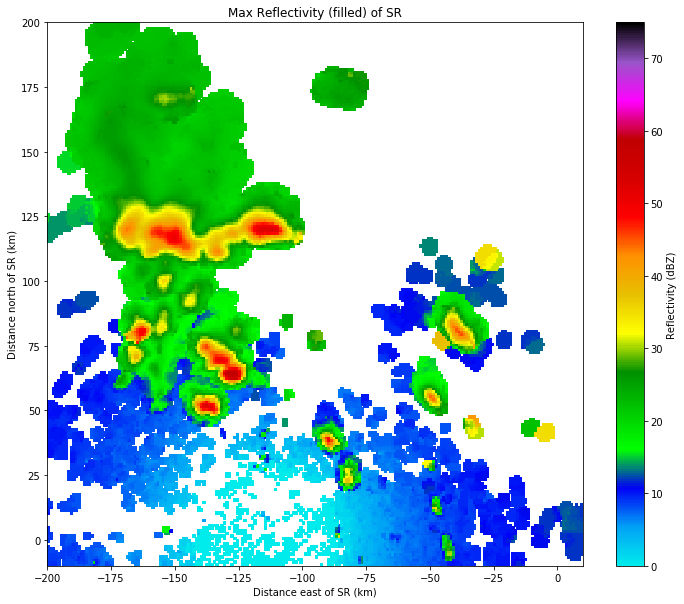

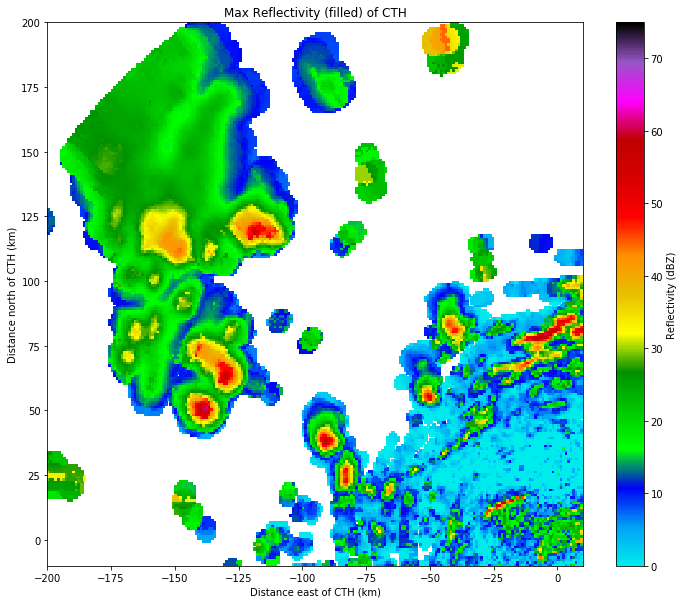

In [13]:
fig = plt.figure(figsize=(12, 10))
fig.set_facecolor('w')
DZcomp = np.amax(grid_1.fields['DT']['data'], axis=0)
x, y = np.meshgrid(0.001*grid_1.x['data'], 0.001*grid_1.y['data'])
cs = plt.pcolormesh(0.001*grid_1.x['data'], 0.001*grid_1.y['data'],
                    DZcomp, vmin=0, vmax=75, cmap='pyart_NWSRef')
plt.xlim(-200, 10)
plt.ylim(-10, 200)
plt.colorbar(cs, label='Reflectivity (dBZ)')
plt.title('Max Reflectivity (filled) of SR')
plt.xlabel('Distance east of SR (km)')
plt.ylabel('Distance north of SR (km)')

fig = plt.figure(figsize=(12, 10))
fig.set_facecolor('w')
DZcomp = np.amax(grid_2.fields['DT']['data'], axis=0)
x, y = np.meshgrid(0.001*grid_2.x['data'], 0.001*grid_2.y['data'])
cs = plt.pcolormesh(0.001*grid_2.x['data'], 0.001*grid_2.y['data'],
                    DZcomp, vmin=0, vmax=75, cmap='pyart_NWSRef')
plt.xlim(-200, 10)
plt.ylim(-10, 200)
plt.colorbar(cs, label='Reflectivity (dBZ)')
plt.title('Max Reflectivity (filled) of CTH')
plt.xlabel('Distance east of CTH (km)')
plt.ylabel('Distance north of CTH (km)')

In [14]:
pyart.io.write_grid('sr.nc', grid_1)
pyart.io.write_grid('cth.nc', grid_2)

In [15]:
# You don't have to define everything. Most of these keywords are default values.
# If you don't define something the program will provide a default value.
# Check parameters.py for what keyword default values are.
localfile = tempfile.NamedTemporaryFile()
pd = {'dir': './',
      'x': [-200000.0, 1000.0, 211],
      'y': [-10000.0, 1000.0, 211],
      'z': [1000.0, 1000.0,  20],
      'grid': [grid_1.origin_longitude['data'][0], grid_1.origin_latitude['data'][0], 0.0],
      'files': ['sr.nc',
                'cth.nc'],
      'radar_names': ['SR', 'CTH'],
      'refl': 'DT',  # Name of reflectivity field. Must be common between radars.
      'vt': 'VT',  # Name of velocity field. Must be common between radars.
      'bgfile': None,
      'writeout': localfile.name,
      'min_cba': 20.0,  # Minimum beam-crossing angle
      'calc_params': 'calc.dda',
      'anel': 1,
      'laplace': 0,
      'read_dataweights': 2,
      'max_dist': 10.0,
      'cutoff': 0.0,
      'UT': 0.0,
      'VT': 0.0,
      'output_error': 0,
      'weak_height': -1,
      'upper_bc': 1,
      'itmax_frprmn': [200, 10],
      'itmax_dbrent': 200,
      'C1b': 1.0,  # Data weighting factor
      'C2b': 10.0,  # Mass continuity weighting factor
      'C3b': 0,  # Vorticity weighting factor
      'C4b': 1.0,  # Horizontal smoothing factor
      'C5b': 0.0,  # Vertical smoothing factor
      'C8b': 0.0,  # Sounding factor
      'vary_weights': 0,
      'filter': ['none', '', ''],
      'cvg_opt_bg': [1, 1, 1],
      'cvg_sub_bg': [1, 1, 1],
      'cvg_opt_fil': [0, 1, 1],
      'cvg_sub_fil': [0, 0, 0],
      'cvg_bg': [0, 0, 0],
      'cvg_fil': [0, 0, 0],
      'sseq_trip': [1.0, 1.0, 0.0]
     }
pf = multidop.parameters.ParamFile(pd, 'example.dda')
pf = multidop.parameters.CalcParamFile(pd, 'calc.dda')

In [16]:
# Unfortunately, text output from the analysis engine (DDA) will not display
# until after the program completes. Expect this step to take several minutes.
bt = time.time()
multidop.execute.do_analysis('example.dda', cmd_path='src/DDA')
print((time.time()-bt)/60.0, 'minutes to process')

DDA 0.9.0
./DDA: reading calculation parameters from calc.dda.
Changing working directory to ./
x: -200000.000000 to 10000.000000 in 210 steps of 1000.000000
y: -10000.000000 to 200000.000000 in 210 steps of 1000.000000
z: 1000.000000 to 20000.000000 in 19 steps of 1000.000000
z_min=1000, cutoff=0
UT=0, VT=0
Anelastic mass cons
First-order smoothness constraint
Minimum beam crossing angle = 20 degrees
Py-ART grids for analyis and all radars must match to within (dx, dy, dz) < (10 10 10) meters.
Reading Py-ART filesr.nc
cth.nc

Radar positions:  (-114194,-581.287) (0.12019,-0.0946679)
Computing coverage: 84501 verification points out of 890420 total points.
radar0 100226 obs. radar1 160487 obs. 260713 total obs.
Analyzed obs = 260713. Mean Vr = 5.13216
C1b=1 C2b=10 C3b=0 C4b=1 C5b=0 C6b=0 C7b=1 C8b=0
C2a=10 C3a=0 C4a=1 C5a=0 C6a=0 C7a=1 C8a=0
Weighting all obs equally!
GradCheck: rchek = 1e+10. fx1 = 142450
GradCheck: gxnn = 30359.2
GradCheck: j = 1. fx2 = 2.005e+21. ffff = 6.604e+07
Gr

In [17]:
# Baseline output is not CF or Py-ART compliant. This function fixes that.
# This is why we wrote the original output to a tempfile that can be safely removed.
# The final grid will have all wind solutions outside the coverage region masked.
fname = 'cf_compliant_grid.nc'
final_grid = multidop.grid_io.make_new_grid([grid_1, grid_2], localfile.name)
final_grid.write(fname)
localfile.close()

## Reading results in Py-ART

In [18]:
pyart_grid = pyart.io.read_grid(fname)
pyart_grid =final_grid
print(pyart_grid.fields.keys())

['eastward_wind', 'upward_air_velocity', 'northward_wind', 'reflectivity']


## First look

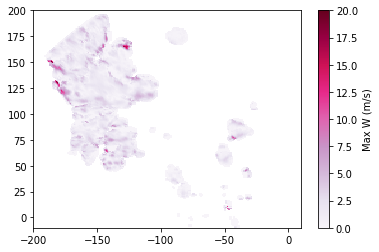

In [19]:
cs = plt.pcolormesh(0.001*pyart_grid.x['data'], 0.001*pyart_grid.y['data'],
                    np.amax(pyart_grid.fields['upward_air_velocity']['data'], axis=0),
                    vmin=0, vmax=20, cmap='PuRd')
plt.colorbar(cs, label='Max W (m/s)')

Text(0,0.5,'Distance north of CTH (km)')

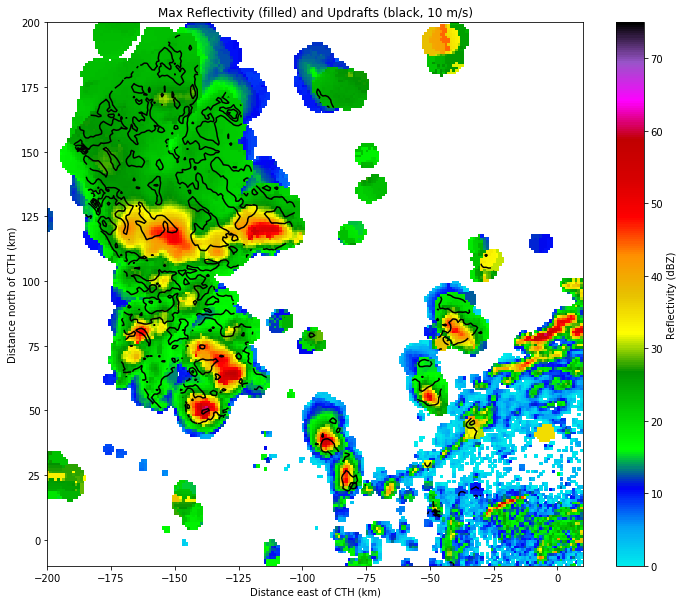

In [20]:
fig = plt.figure(figsize=(12, 10))
fig.set_facecolor('w')
DZcomp = np.amax(pyart_grid.fields['reflectivity']['data'], axis=0)
x, y = np.meshgrid(0.001*pyart_grid.x['data'], 0.001*pyart_grid.y['data'])
cs = plt.pcolormesh(0.001*pyart_grid.x['data'], 0.001*pyart_grid.y['data'],
                    DZcomp, vmin=0, vmax=75, cmap='pyart_NWSRef')
Wcomp = np.amax(pyart_grid.fields['upward_air_velocity']['data'], axis=0)
plt.contour(x, y, Wcomp, levels=[1, 6, 11, 16, 21], colors=['k', 'k', 'k'])
plt.xlim(-200, 10)
plt.ylim(-10, 200)
plt.colorbar(cs, label='Reflectivity (dBZ)')
plt.title('Max Reflectivity (filled) and Updrafts (black, 10 m/s)')
plt.xlabel('Distance east of CTH (km)')
plt.ylabel('Distance north of CTH (km)')

## Focusing on system

In [21]:
# Selecting data
U = pyart_grid.fields['eastward_wind']['data']
V = pyart_grid.fields['northward_wind']['data']
W = pyart_grid.fields['upward_air_velocity']['data']
Z = pyart_grid.fields['reflectivity']['data']

# Grid
x, y = np.meshgrid(0.001*pyart_grid.x['data'], 0.001*pyart_grid.y['data'])

# General setup
ind = 2 # level
thin = 2 # wind grid

# Wind medians - necessary?
Um = np.ma.median(U[ind])
Vm = np.ma.median(V[ind])

### Horizontal view

Text(0.5,1,'CTH/SR U & V, W (contours, m/s), & dBZ @ 3 km MSL')

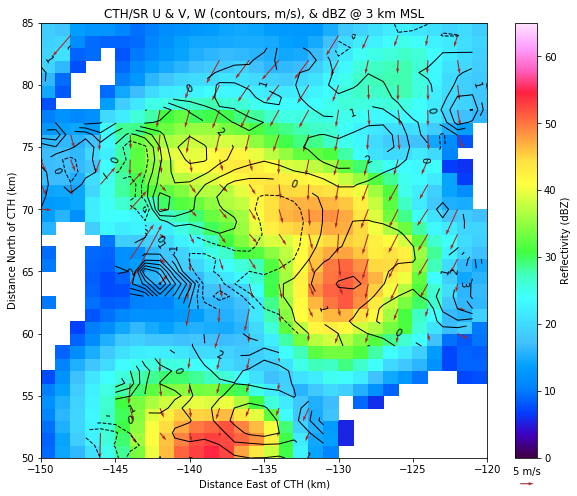

In [23]:
# Main figure
fig = plt.figure(figsize=(10, 8))
fig.set_facecolor('w')
ax = fig.add_subplot(111)

# Reflectivity (shaded)
cs = ax.pcolormesh(0.001*pyart_grid.x['data'], 0.001*pyart_grid.y['data'],
                   Z[ind], vmin=0, vmax=65, cmap=cm.GMT_wysiwyg)
plt.colorbar(cs, label='Reflectivity (dBZ)', ax=ax)

# Vertical wind (contour)
cl = plt.contour(x, y, W[ind], levels=range(-20, 20), colors=['k'], linewidths=1)
plt.clabel(cl, inline=1, fontsize=10, fmt='%1.0f', inline_spacing=0.01)

# Wind arrows
wind = ax.quiver(x[::thin, ::thin], y[::thin, ::thin], U[ind][::thin, ::thin],
                 V[ind][::thin, ::thin], scale=5, units='xy',
                 color='brown', label='Winds (m/s)')
ax.quiverkey(wind, 0.8, 0.08, 5, '5 m/s', coordinates='figure')

# General aspects
ax.set_xlim(-150, -120)
ax.set_ylim(50, 85)
ax.set_xlabel('Distance East of CTH (km)')
ax.set_ylabel('Distance North of CTH (km)')
ax.set_title('CTH/SR U & V, W (contours, m/s),' +
             ' & dBZ @ '+str(ind+1)+' km MSL')

### Vertical view

In [24]:
# Grid
y_cs, z_cs = np.meshgrid(0.001*pyart_grid.y['data'], 0.001*pyart_grid.z['data'])

# Wind medians - necessary?
Wm = np.ma.median([W[i][:,71] for i in range(0,20)])

Text(0.5,1,'CTH/SR V & W, W (contours, m/s), & dBZ @ -129.0 km East of CTH')

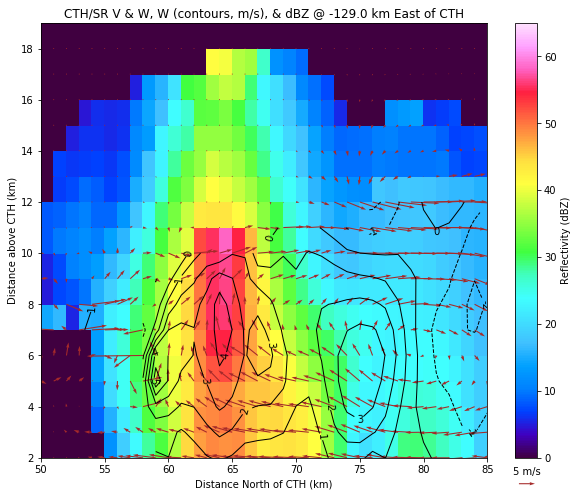

In [25]:
# Main figure
fig = plt.figure(figsize=(10, 8))
fig.set_facecolor('w')
ax = fig.add_subplot(111)

# Reflectivity (shaded)
cs = ax.pcolormesh(0.001*pyart_grid.y['data'], 0.001*pyart_grid.z['data'],
                   [Z[i][:,71] for i in range(0,20)], vmin=0, vmax=65,
                   cmap=cm.GMT_wysiwyg)
plt.colorbar(cs, label='Reflectivity (dBZ)', ax=ax)

# Vertical wind (contour)
cl = plt.contour(y_cs, z_cs, [W[i][:,71] for i in range(0,20)], 
                 levels=range(-20, 20), colors=['k'], linewidths=1)
plt.clabel(cl, inline=1, fontsize=10, fmt='%1.0f', inline_spacing=0.01)

# Wind barbs
wind = ax.quiver(y_cs, z_cs, [V[i][:,71] for i in range(0,20)],
                 [W[i][:,71] for i in range(0,20)], scale=5, units='xy', 
                 color='brown', label='Winds (m/s)')
ax.quiverkey(wind, 0.8, 0.08, 5, '5 m/s', coordinates='figure')

ax.set_xlim(50, 85)
ax.set_ylim(2,19)
ax.set_xlabel('Distance North of CTH (km)')
ax.set_ylabel('Distance above CTH (km)')
ax.set_title('CTH/SR V & W, W (contours, m/s),' +
             ' & dBZ @ '+str(x[0,71])+' km East of CTH')